#📌 Extracão

In [41]:
import requests
import pandas as pd

In [42]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

response = requests.get(url)
response.raise_for_status()

data_json = response.json()

df = pd.DataFrame(data_json)

print(df.head())

   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'I

#🔧 Transformação

In [43]:
# Quantidade de valores ausentes por coluna
df.isnull().sum()

(df.isnull().sum() / len(df)) * 100

,0
customerID,0.0
Churn,0.0
customer,0.0
phone,0.0
internet,0.0
account,0.0


In [44]:
# Verificando registros duplicados
cols_dict = []
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, dict)).any():
        cols_dict.append(col)

print(f"Colunas com dict: {cols_dict}")

for col in cols_dict:
    df = pd.json_normalize(df[col]).add_prefix(f'{col}.').merge(df.drop(columns=[col]), left_index=True, right_index=True)

print("Duplicados:", df.duplicated().sum())
df = df.drop_duplicates()

Colunas com dict: ['customer', 'phone', 'internet', 'account']
Duplicados: 0


In [45]:
# Contagem de Valores
display(df['customer.gender'].value_counts())
display(df['account.PaymentMethod'].value_counts())

,count
customer.gender,
Male,3675
Female,3592


,count
account.PaymentMethod,
Electronic check,2445
Mailed check,1665
Bank transfer (automatic),1589
Credit card (automatic),1568


In [46]:
df['customer.tenure'].describe()

,customer.tenure
count,7267.000000
mean,32.346498
std,24.571773
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,72.000000


In [47]:
# Coluna Contas Diarias
df['Contas_Diarias'] = df['account.Charges.Monthly'] / 30
print(df['Contas_Diarias'].describe())

count    7267.000000
mean        2.157337
std         1.004319
min         0.608333
25%         1.180833
50%         2.343333
75%         2.995833
max         3.958333
Name: Contas_Diarias, dtype: float64


In [48]:
#Conversão de valores Yes or No para Binário
binary_cols = []
for col in df.columns:
    unique_values = df[col].unique()
    if len(unique_values) == 2:
        lower_unique = [str(val).lower() for val in unique_values]
        if set(lower_unique) == {'yes', 'no'}:
            binary_cols.append(col)

print("Columns identified for binary conversion:", binary_cols)

Columns identified for binary conversion: ['account.PaperlessBilling', 'phone.PhoneService', 'customer.Partner', 'customer.Dependents']


#📊 Carga e análise

In [49]:
# Realizar análise descritiva dos dados
display(df.describe())

,account.Charges.Monthly,customer.SeniorCitizen,customer.tenure,Contas_Diarias
count,7267.000000,7267.000000,7267.000000,7267.000000
mean,64.720098,0.162653,32.346498,2.157337
std,30.129572,0.369074,24.571773,1.004319
min,18.250000,0.000000,0.000000,0.608333
25%,35.425000,0.000000,9.000000,1.180833
50%,70.300000,0.000000,29.000000,2.343333
75%,89.875000,0.000000,55.000000,2.995833
max,118.750000,1.000000,72.000000,3.958333


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

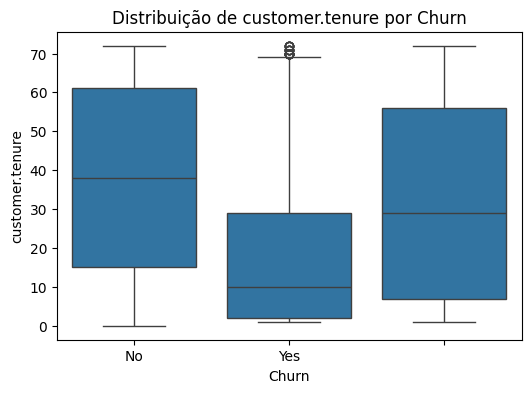

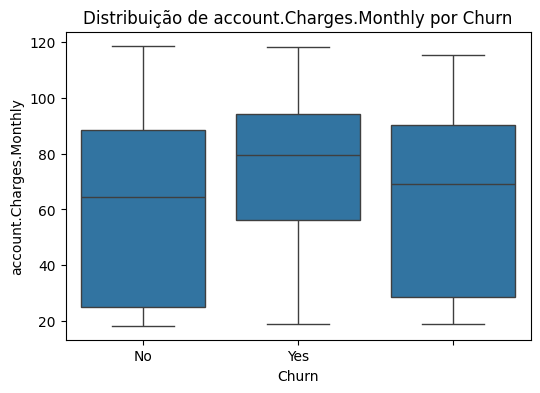

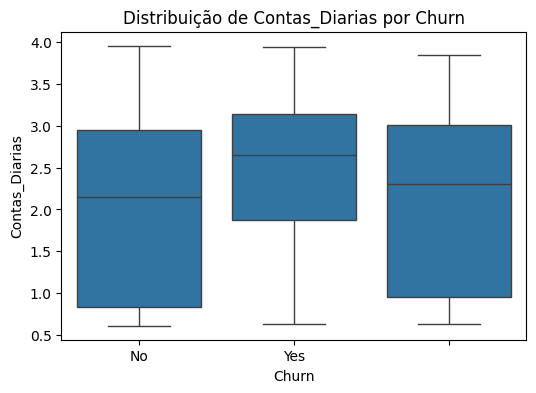

In [58]:
# Define the list of numerical columns to plot
num_cols = ['customer.tenure', 'account.Charges.Monthly', 'Contas_Diarias']

# Generate box plots for each numerical column against 'Churn'
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'Distribuição de {col} por Churn')
    plt.show()

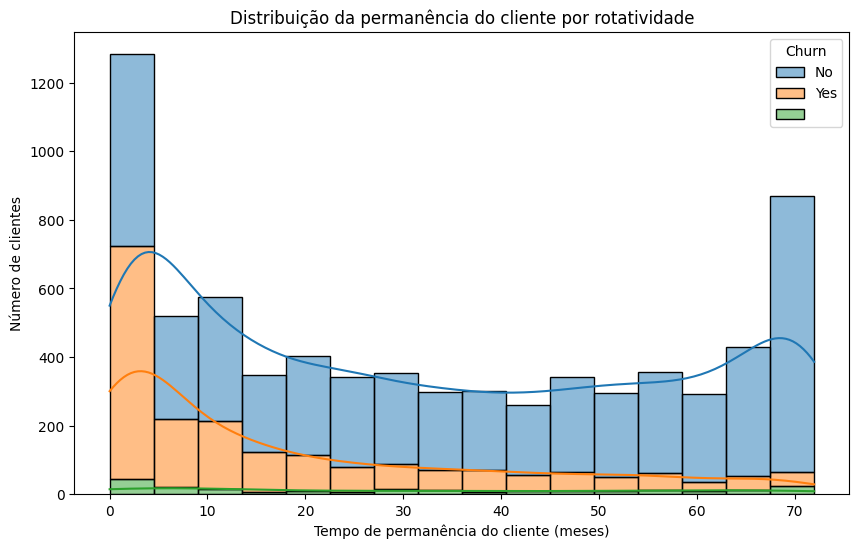

In [55]:
# Contagem de Evasão por Variáveis Numéricas
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='customer.tenure', hue='Churn', multiple='stack', kde=True)
plt.title('Distribuição da permanência do cliente por rotatividade')
plt.xlabel('Tempo de permanência do cliente (meses)')
plt.ylabel('Número de clientes')
plt.show()

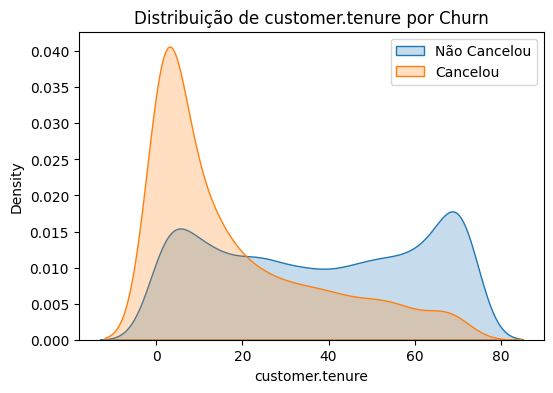

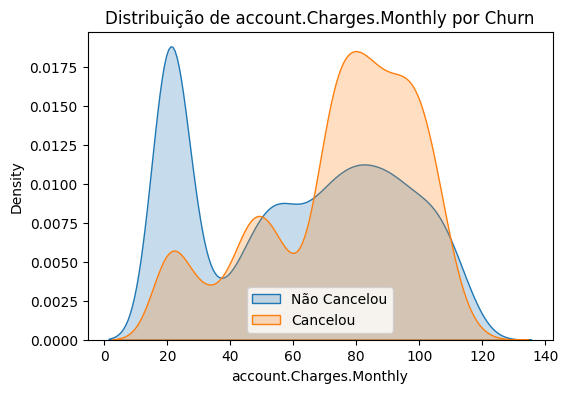

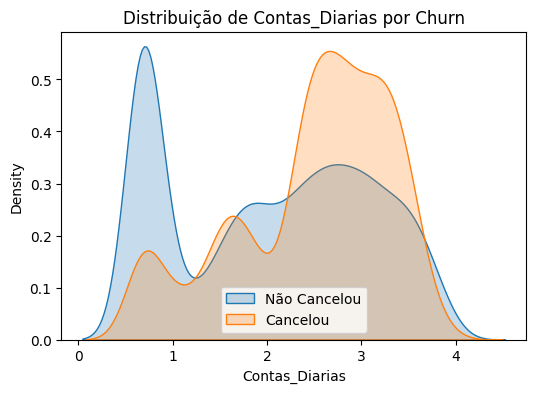

In [61]:
num_cols = ['customer.tenure', 'account.Charges.Monthly', 'Contas_Diarias']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[df['Churn']=='No'][col], label='Não Cancelou', fill=True)
    sns.kdeplot(df[df['Churn']=='Yes'][col], label='Cancelou', fill=True)
    plt.title(f'Distribuição de {col} por Churn')
    plt.legend()
    plt.show()

Contagem de Evasão por Variáveis Categóricas

In [64]:
df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

cat_cols = ['customer.gender', 'account.Contract', 'account.PaymentMethod', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'internet.InternetService']

for col in cat_cols:
    print(f"Taxa de Churn por {col}:")
    print(df.groupby(col)['Churn_numeric'].mean())
    print("\n")

Taxa de Churn por customer.gender:
customer.gender
Female    0.261414
Male      0.253061
Name: Churn_numeric, dtype: float64


Taxa de Churn por account.Contract:
account.Contract
Month-to-month    0.413233
One year          0.109282
Two year          0.027539
Name: Churn_numeric, dtype: float64


Taxa de Churn por account.PaymentMethod:
account.PaymentMethod
Bank transfer (automatic)    0.162366
Credit card (automatic)      0.147959
Electronic check             0.438037
Mailed check                 0.184985
Name: Churn_numeric, dtype: float64


Taxa de Churn por customer.Partner:
customer.Partner
No     0.320085
Yes    0.190165
Name: Churn_numeric, dtype: float64


Taxa de Churn por customer.Dependents:
customer.Dependents
No     0.303382
Yes    0.149473
Name: Churn_numeric, dtype: float64


Taxa de Churn por phone.PhoneService:
phone.PhoneService
No     0.240453
Yes    0.258994
Name: Churn_numeric, dtype: float64


Taxa de Churn por internet.InternetService:
internet.InternetService


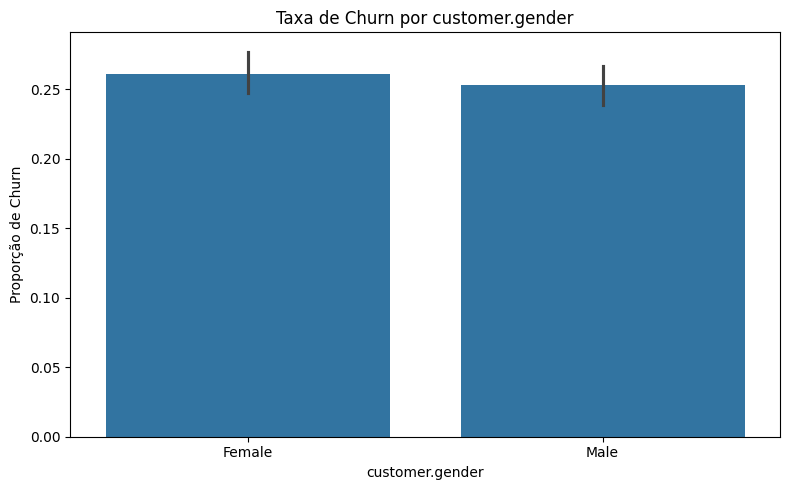

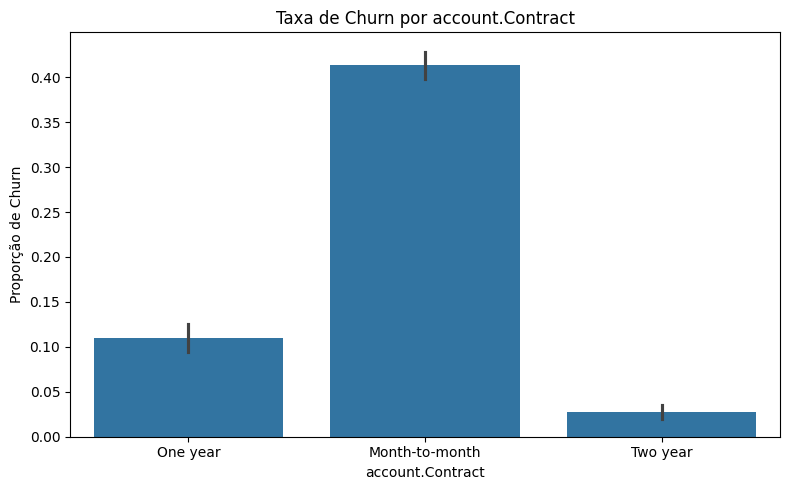

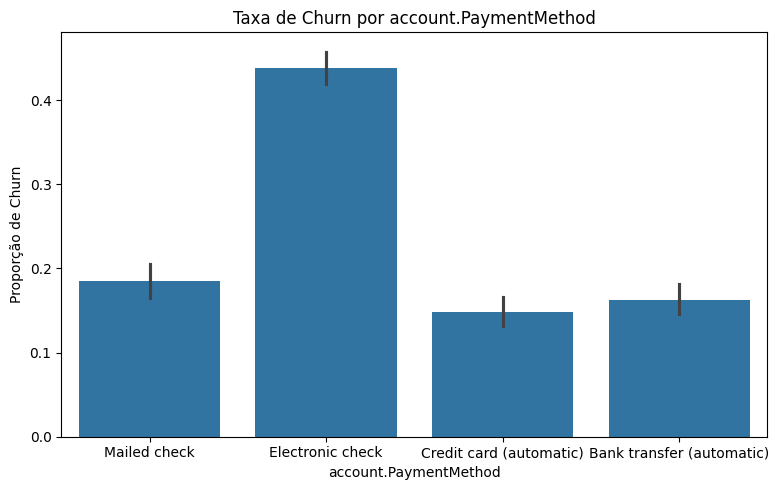

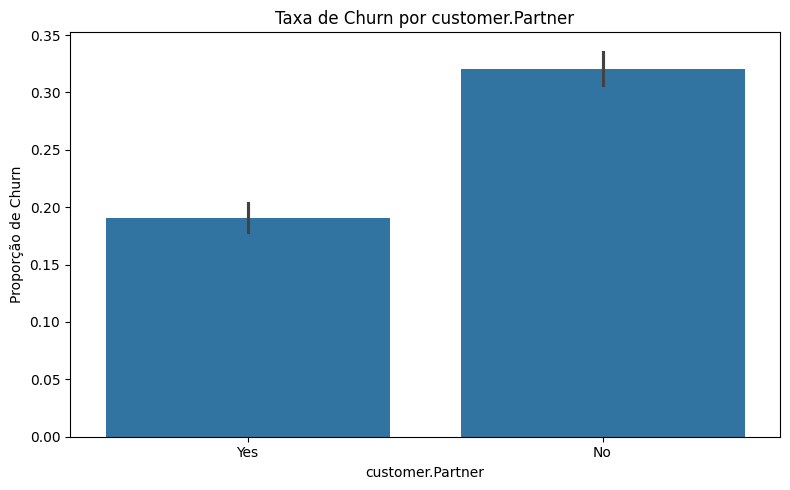

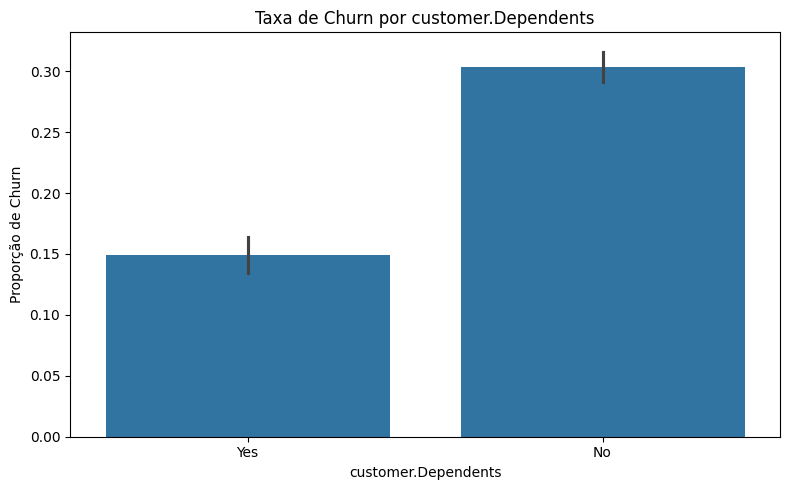

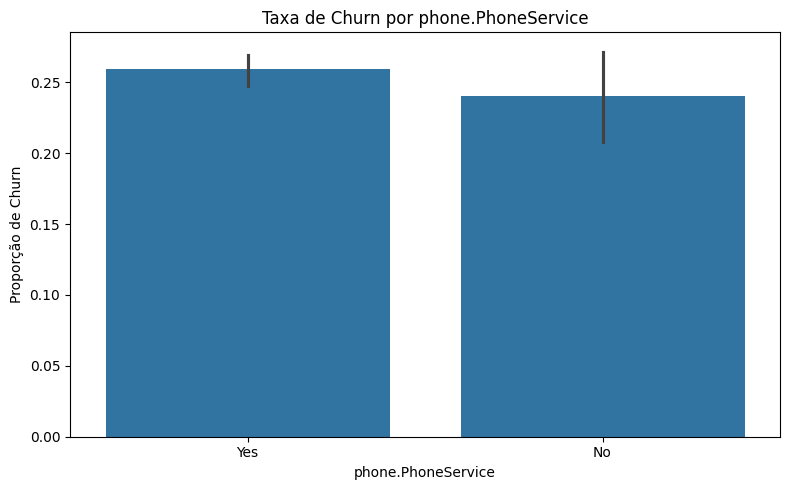

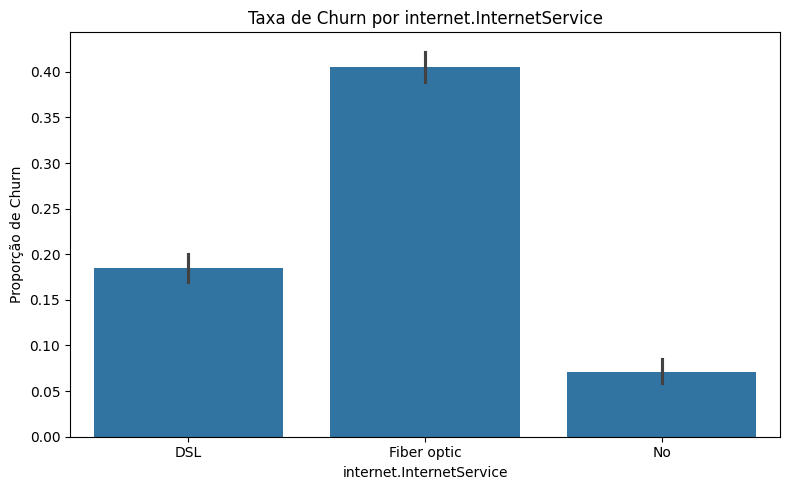

In [66]:
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=col, y='Churn_numeric', data=df)
    plt.title(f'Taxa de Churn por {col}')
    plt.ylabel('Proporção de Churn')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#📄Relatorio Final